<a href="https://colab.research.google.com/github/nice-digital/nice-ds-kidneycancer/blob/master/kidneycancer/code/preprocess_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kidney Cancer Pre-Processing Colab**

This notebook is the first stage in Breast cancer processing, and does the necessary pre-processing of the input data- title & abstracts

Please name your data file input_data.csv (title column should be named 'Title' or 'title' and abstract column if present should be named 'Abstract' or 'abstract'), and upload it by pressing the upload button on the top left of the left sidebar. The results will appear in a folder named RESULTS. RESULTS folder will be automatically created by the code


In [1]:
#@title Install Python packages { form-width: "20%" }
#joe test
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to download and import third-party software
#@markdown in this Colab notebook.

#@markdown This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.

from IPython.utils import io
try:
  with io.capture_output() as captured:
    %shell pip install scispacy
    %shell pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_md-0.5.0.tar.gz
    %shell pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz
    %shell pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz
    %shell pip install pyLDAvis==2.1.2
    %shell pip install import-ipynb
    %shell pip install pandas
    %shell pip install shutup

except subprocess.CalledProcessError:
  print(captured)
  raise
import shutup
shutup.please()

import os
import numpy as np
import spacy
import scispacy
import pandas as pd
from scispacy.abbreviation import AbbreviationDetector

from pathlib import Path
import collections
import csv
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from spacy.matcher import Matcher
import multiprocessing as mp
from multiprocessing import Pool

 # Load relevant Spacy models
nlp = spacy.load("en_core_sci_md")
nlpDiseaseChem = spacy.load("en_ner_bc5cdr_md")
nlpcancer = spacy.load("en_ner_bionlp13cg_md")

# Add the abbreviation pipe to the spacy pipeline.
nlp.add_pipe("abbreviation_detector")
cpu_count = mp.cpu_count()

pd. set_option('display.max_colwidth', None)

In [2]:
#@title File settings to get started { form-width: "20%" }

#@markdown Please ensure the input_data.csv is uploaded and execute this cell by pressing the _Play_ button
#@markdown on the left
DATA_PATH = 'input_data.csv'

results_folder = 'RESULTS'
RESULTS_FOLDER = results_folder     #***user input
if not os.path.isdir(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)
RESULTS_PATH = Path(RESULTS_FOLDER)

In [29]:
#@title Read in input data { form-width: "20%" }
lit_data = pd.read_csv(DATA_PATH)
lit_data.rename(columns = {'Title':'title', 'Abstract': 'abstract'}, inplace = True)
print("Number of studies in the original dataset: " + str(lit_data.shape[0]))
lit_data.drop_duplicates(subset=['title'], inplace=True)
lit_data['title_orig'] = lit_data['title']
lit_data['abstract_orig'] = lit_data['abstract']
print("Number of studies in the dataset after de-dupe: " + str(lit_data.shape[0]))

Number of studies in the original dataset: 4337
Number of studies in the dataset after de-dupe: 4334


In [30]:
#@title Pre-process input data: Replace acronyms by its long form (do this before any case change/punctuation processing) { form-width: "20%" }
def replace_acronyms(txt):
  """ Replace the acronyms with it's long form
    :param txt: txt which has acronyms
    :return: txt with acronyms replaced with its long form or original txt if an exception occured
  """
  try:
    doc = nlp(txt)
    altered_tok = [tok.text for tok in doc]
    for abrv in doc._.abbreviations:
      altered_tok[abrv.start] = str(abrv._.long_form)
    full_txt = " ".join(altered_tok)
  except:
    return (txt)
  return(full_txt)

with mp.Pool(cpu_count) as pool:
  lit_data['title'] = pool.map(replace_acronyms, lit_data['title'])
with mp.Pool(cpu_count) as pool:
  lit_data['abstract'] = pool.map(replace_acronyms, lit_data['abstract'])

In [31]:
#@title Clone the SciLiteratureProcessing GITHub repo to access pre-processing code { form-width: "20%" }

!git clone https://github.com/nice-digital/SciLiteratureProcessing

fatal: destination path 'SciLiteratureProcessing' already exists and is not an empty directory.


In [32]:
#@title This defines code which will be used for pre-processing, identifying study design/categories.

%cd /content/SciLiteratureProcessing/code/

# Function definitions to pre-process title and abstract
%run -i "text_preprocess.py"

# Function definitions for pattern matching
%run -i "text_patternmatch.py"

%cd /content/

/content/SciLiteratureProcessing/code
/content


<Figure size 640x480 with 0 Axes>

In [33]:
#@title SR & RCT pattern matching { form-width: "20%" }
lit_data = preproc_title(lit_data)
lit_data = preproc_abstract(lit_data)
lit_data['Syst-Meta'] = lit_data.apply(match_studydesign_systematicrev, axis=1)
lit_data['RCT'] = lit_data.apply(match_studydesign_RCT, axis=1)

In [34]:
#@title Add valid entities not picked up by NER models- BC code, delete if not valid { form-width: "20%" }
DISEASE_ENTS = ['triple negative breast cancer']
CANCER_ENTS = ['mastectomy']
DRUGS_ENTS = ['palbociclib', 'inetetamab', 'avelumab', 'camrelizumab','carvedilol', 'eryaspase ', 'imlunestrant', 'inavolisib', 'leucostim', 'alpelisib']

In [35]:
#@title Medical entity extraction { form-width: "20%" }
def extract_entities(record):
  """ Extract medical entities from the txt (title/abstract), results of three medical entity models are returned
    :param record: a row in the dataframe
    :return: fields which represent medical entities
  """
  med_list = []
  disease_list = []
  chemical_list = []
  ent_list = []
  cancer_list = []
  cancer_med_title = []
  unique_disease_list = []
  unique_chemical_list = []
  unique_med_list = []
  unique_ent_list = []
  unique_cancer_list = []
  unique_cancer_notmed_list = []
  try:
    #abstract = record[col]
    abstract = record
    doc_sci = nlp(abstract)
    doc_diseasechem = nlpDiseaseChem(abstract)
    doc_cancer = nlpcancer(abstract)
    #displacy.render(doc_diseasechem,style='ent',jupyter=True)
    #displacy.render(doc_cancer,style='ent',jupyter=True)
    for ent in doc_sci.ents:
      ent_list.append(ent.text)
      if (ent.text not in unique_ent_list):
        unique_ent_list.append(ent.text)

    for ent in doc_diseasechem.ents:
      med_list.append(ent.text)
      if (ent.text not in unique_med_list):
        unique_med_list.append(ent.text)
      if ent.label_ == 'DISEASE':
        disease_list.append(ent.text)
        if (ent.text not in unique_disease_list):
          unique_disease_list.append(ent.text)
      if ent.label_ == 'CHEMICAL':
        chemical_list.append(ent.text)
        if (ent.text not in unique_chemical_list):
          unique_chemical_list.append(ent.text)

    for ent in doc_cancer.ents:
      cancer_list.append(ent.text)
      if (ent.text not in unique_cancer_list):
        unique_cancer_list.append(ent.text)
      if (ent.text not in unique_med_list):
        unique_cancer_notmed_list.append(ent.text)
    return pd.Series([med_list, disease_list, chemical_list, cancer_list, ent_list, unique_med_list, unique_disease_list, unique_chemical_list, unique_cancer_list, unique_cancer_notmed_list, unique_ent_list])
  except Exception as e:
    # Empty list will be returned
    return pd.Series([med_list, disease_list, chemical_list, cancer_list, ent_list, unique_med_list, unique_disease_list, unique_chemical_list, unique_cancer_list, unique_cancer_notmed_list, unique_ent_list])

with mp.Pool(cpu_count) as pool:
  lit_data[['medTokens_title', 'med_disease_title', 'med_chem_title', 'cancerTokens_title','entTokens_title', 'uniqueMed_title', 'uniqueDisease_title','uniqueChemical_title','uniqueCancer_title', 'uniqueCancerNotmed_title', 'uniqueEnt_title']] = pool.map(extract_entities, lit_data['title'])
with mp.Pool(cpu_count) as pool:
  lit_data[['medTokens_abs', 'med_disease_abs', 'med_chem_abs', 'cancerTokens_abs','entTokens_abs', 'uniqueMed_abs', 'uniqueDisease_abs','uniqueChemical_abs','uniqueCancer_abs', 'uniqueCancerNotmed_abs', 'uniqueEnt_abs']] = pool.map(extract_entities, lit_data['abstract'])
#lit_data[['medTokens_title', 'med_disease_title', 'med_chem_title', 'cancerTokens_title','entTokens_title', 'uniqueMed_title', 'uniqueDisease_title','uniqueChemical_title','uniqueCancer_title', 'uniqueCancerNotmed_title', 'uniqueEnt_title']] = lit_data.apply((lambda row: extract_entities(row, 'title')), axis = 1)
#lit_data[['medTokens_abs', 'med_disease_abs', 'med_chem_abs', 'cancerTokens_abs','entTokens_abs', 'uniqueMed_abs', 'uniqueDisease_abs','uniqueChemical_abs','uniqueCancer_abs', 'uniqueCancerNotmed_abs', 'uniqueEnt_abs']] = lit_data.apply((lambda row: extract_entities(row, 'abstract')), axis = 1)

In [36]:
#@title utility function, delete if not needed
# combine two lists and de-dup
def exclude_duplicates(list):
  return ([*set(list)])



In [37]:
#@title Write the results out { form-width: "20%" }
lit_data.to_csv(RESULTS_PATH / "preprocessed_full.csv", index=False)

In [38]:
#@title Write a tidy version of results { form-width: "20%" }
#error fix - add blank cols for now
lit_data['cancer_med_title'] = lit_data['uniqueMed_title'] + lit_data['uniqueCancer_title']
lit_data['cancer_med_abstract'] = lit_data['uniqueMed_abs'] + lit_data['uniqueCancer_abs']

#current code
lit_data['medTokens'] = lit_data['medTokens_title'] + lit_data['medTokens_abs']
lit_data['medTokens_disease'] = lit_data['med_disease_title'] + lit_data['med_disease_abs']
lit_data['unique_med_disease'] = lit_data['medTokens_disease'].apply(exclude_duplicates)
lit_data['medTokens_chemical'] = lit_data['med_chem_title'] + lit_data['med_chem_abs']
lit_data['unique_med_chemical'] = lit_data['medTokens_chemical'].apply(exclude_duplicates)
lit_data['cancerTokens'] = lit_data['cancerTokens_title'] + lit_data['cancerTokens_abs']
lit_data['entTokens'] = lit_data['entTokens_title'] + lit_data['entTokens_abs']
lit_data['unique_cancer_med'] = lit_data['cancer_med_title'] + lit_data['cancer_med_abstract']
lit_data['unique_cancer_med'] = lit_data['unique_cancer_med'].apply(exclude_duplicates)
lit_data['unique_entTokens'] = lit_data['entTokens'].apply(exclude_duplicates)
lit_data_subset = lit_data[['title', 'abstract', 'title_orig', 'abstract_orig', 'Syst-Meta', 'RCT','medTokens','medTokens_disease',
                           'medTokens_chemical', 'cancerTokens', 'entTokens', 'unique_entTokens', 'unique_med_disease', 'unique_med_chemical', 'unique_cancer_med']]
lit_data_subset.to_csv(RESULTS_PATH / "preprocessed_clean.csv", index=False)

In [39]:
#@title Exclusion words/phrases for the cells after this one { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left

# Below are the list of irrelevant words for entity model
ENTITY_IRRELEVANT = []
# Below are the list of irrelevant words for medical entity model
MED_IRRELEVANT = ['breast', 'Cancer', 'Breast cancer', 'cancer', 'breast cancer', 'breast cancer ', 'cancer', 'cancers', 'breast cancers', 'objective(s', 'purpose(s', 'tumors', 'patients','patient', 'breast cancer patients']

4334


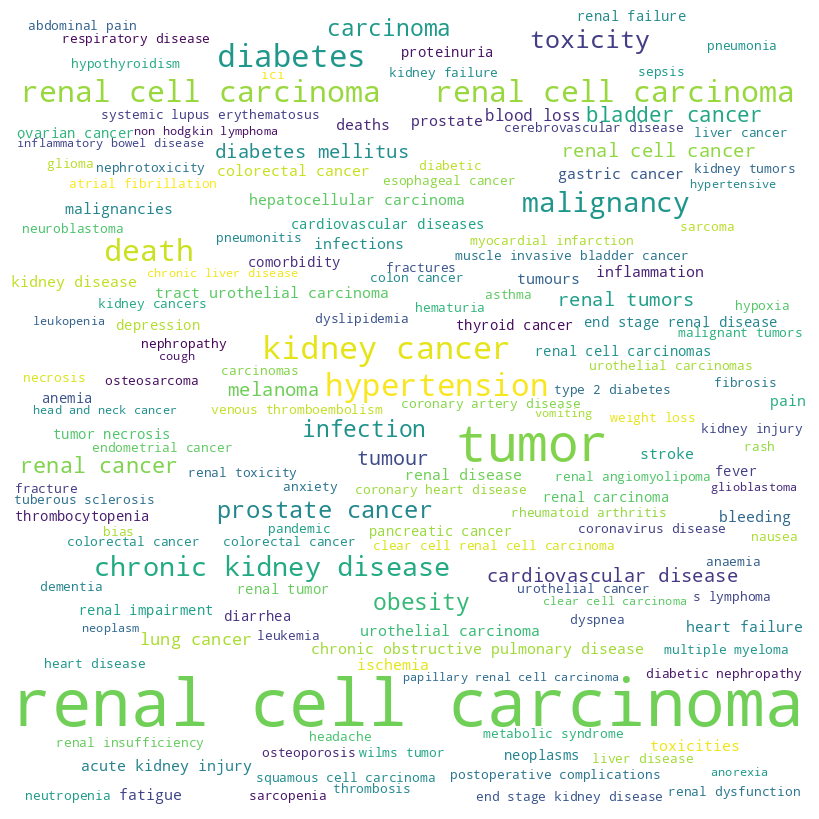

4334


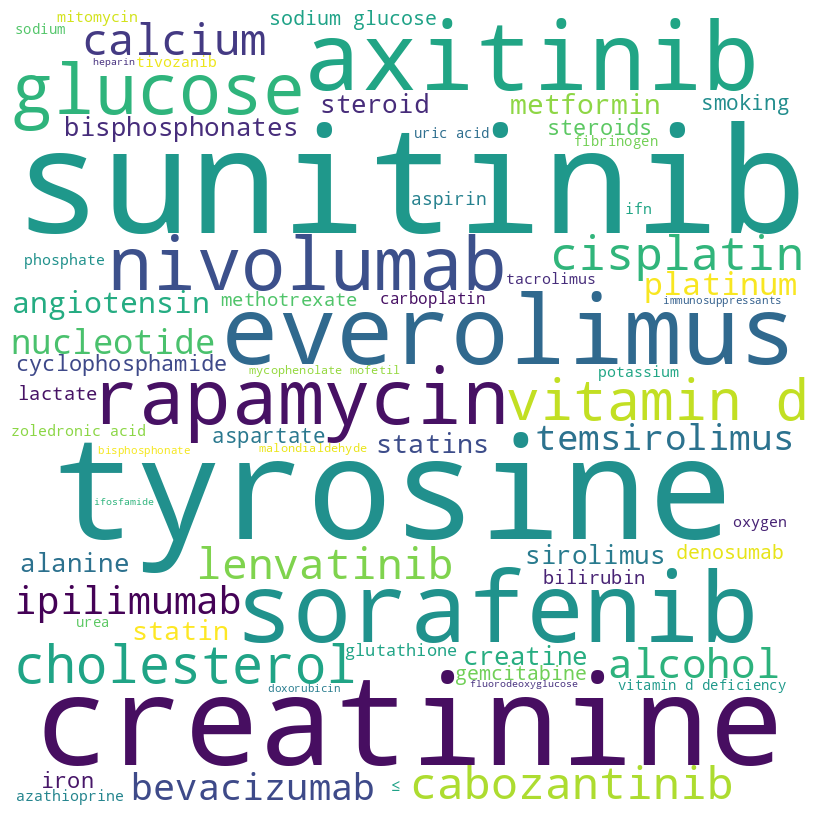

4334


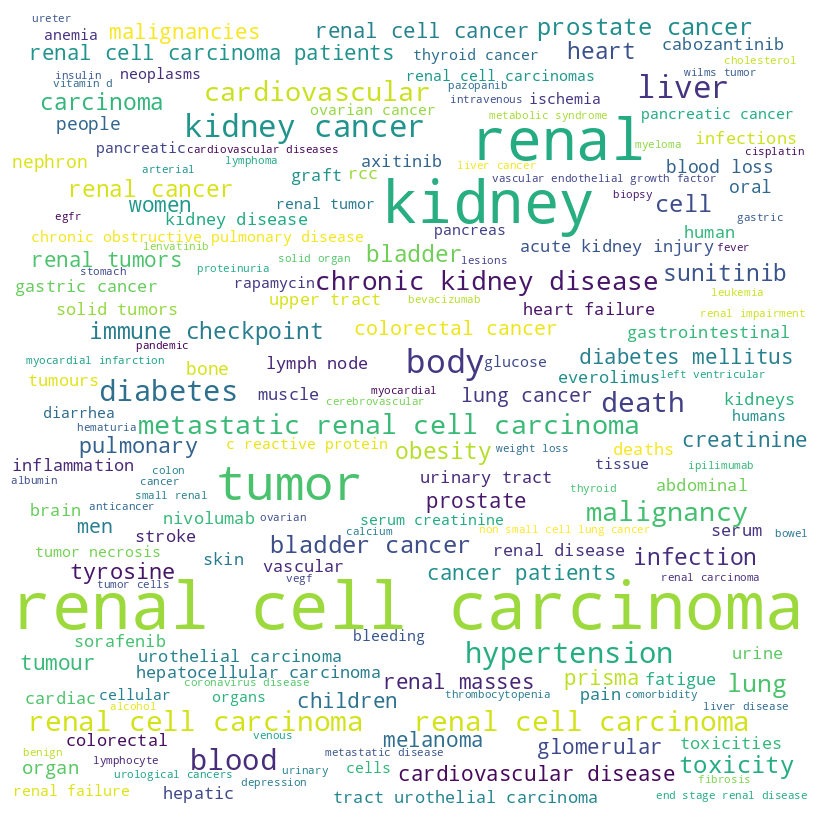

In [40]:
#@title Generate term frequencies and term clouds { form-width: "20%" }

#@markdown Please execute this cell by pressing the _Play_ button on the left


def analyse_termfreq(data_col, freq_fname, wordcloud_fname):
    """ Word clouds and term frequencies
      :param data_col: lit_data column to analyse
      :param data_col: the column in the dataframe to analyse
      :param freq_fname: filename of term freq excel
      :param wordcloud_fname: filename of word cloud
    """
    data = lit_data #only select breast cancer relevant includes edited for missing include JC
    print(data.shape[0])
    data = data[data_col]
    data_list = list([a for b in data.tolist() for a in b])
    l = []
    for x in data_list:
      if x not in MED_IRRELEVANT:
        l.append(x)
    s_counts = collections.Counter(l)
    with open(RESULTS_PATH / freq_fname,'w') as csvfile:
      writer=csv.writer(csvfile)
      writer.writerows(s_counts.items())

    wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = [',', 'cancer', 'cancers', 'Cancer'],
                  relative_scaling = 0.6,
                  prefer_horizontal=1,
                  min_font_size = 10)

    wordcloud.generate_from_frequencies(s_counts, max_font_size=300)
    # Save the image in the img folder:
    wordcloud.to_file(RESULTS_PATH / wordcloud_fname)
    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

analyse_termfreq('unique_med_disease', 'termfreq_disease.csv', 'wordcloud_disease.png')
analyse_termfreq('unique_med_chemical', 'termfreq_chemical.csv', 'wordcloud_chemical.png')
analyse_termfreq('unique_cancer_med', 'termfreq_uniqueCancerMed.csv', 'wordcloud_uniqueCancerMed.png')
#unique_cancer_med not working as term not imported across form BC

In [41]:
#@title Execute this to download the full RESULTS folder as a zip file { form-width: "20%" }

#@markdown Optional to execute this cell.

#@markdown A RESULTS.zip file will be generated on the left pane if you execute this cell
!zip -r /content/RESULTS.zip /content/RESULTS

updating: content/RESULTS/ (stored 0%)
updating: content/RESULTS/termfreq_chemical.csv (deflated 60%)
updating: content/RESULTS/termfreq_uniqueCancerMed.csv (deflated 70%)
updating: content/RESULTS/preprocessed_full.csv (deflated 85%)
updating: content/RESULTS/wordcloud_chemical.png (deflated 0%)
updating: content/RESULTS/wordcloud_disease.png (deflated 1%)
updating: content/RESULTS/preprocessed_clean.csv (deflated 81%)
updating: content/RESULTS/termfreq_disease.csv (deflated 72%)
updating: content/RESULTS/wordcloud_uniqueCancerMed.png (deflated 0%)
